In [35]:
import tensorflow as tf
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [20]:
devices = tf.config.list_physical_devices('GPU')
for device in devices:
  tf.config.experimental.set_memory_growth(device=device, enable=True)

In [21]:
dataset = pd.read_csv('IMDB Dataset.csv')
print(dataset.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [22]:
train_dataset, test_dataset = dataset[:40000], dataset[40000:]
x_train, y_train = train_dataset['review'].to_numpy(), train_dataset['sentiment'].to_numpy()
x_test, y_test = test_dataset['review'].to_numpy(), test_dataset['sentiment'].to_numpy()


In [23]:
max_len = 256 # Maximum sequence length
embedding_dim = 64  # Dimension of word embedding
attention_units = 16 # Attention units for self attention mechanism
num_classes = 2  # Number of output classes

In [24]:
class SelfAttention(tf.keras.layers.Layer):
  def __init__(self, attention_units):
    super(SelfAttention, self).__init__()
    self.attention_units = attention_units

  def build(self, input_shape):
    self.WQ = self.add_weight(shape=(input_shape[-1], self.attention_units),
                              initializer='glorot_uniform',
                              trainable=True)

    self.WK = self.add_weight(shape=(input_shape[-1], self.attention_units),
                              initializer='glorot_uniform',
                              trainable=True)

    self.WV = self.add_weight(shape=(input_shape[-1], self.attention_units),
                              initializer='glorot_uniform',
                              trainable=True)

  def call(self, inputs):
    Q = tf.matmul(inputs, self.WQ)
    K = tf.matmul(inputs, self.WK)
    V = tf.matmul(inputs, self.WV)

    d_k = tf.cast(tf.shape(K)[-1], tf.float32)
    attention_weights = tf.nn.softmax(tf.matmul(Q, K,
                                                transpose_b=True) /
                                      tf.math.sqrt(d_k), axis=-1)
    output = tf.matmul(attention_weights, V)
    return output, attention_weights

In [25]:
class SentimentClassifier(tf.keras.Model):
  def __init__(self, vocab_size, max_len, embedding_dim, attention_units, num_classes):
    super(SentimentClassifier, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len)
    self.positional_encoding = self.positional_encoder(max_len, embedding_dim)
    self.attention = SelfAttention(attention_units)
    self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
    self.dense1 = tf.keras.layers.Dense(256, activation='relu')
    self.dropout = tf.keras.layers.Dropout(0.25)
    self.dense2 = tf.keras.layers.Dense(num_classes, activation='softmax')

  def call(self, input):
    x = self.embedding(input)
    x *= tf.math.sqrt(tf.cast(tf.shape(x)[-1], tf.float32))
    x += self.positional_encoding[:, :tf.shape(x)[1], :]
    output, attention_weights = self.attention(x)

    output = self.global_avg_pool(output)
    output = self.dense1(output)
    output = self.dropout(output)
    output = self.dense2(output)

    return output, attention_weights

  def positional_encoder(self, position, d_model):
    angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads = np.arange(position)[:, np.newaxis] * angle_rates

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.sin(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


In [26]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_dataset['review'])
vocab_size = len(tokenizer.word_index) + 1

In [27]:
X_train_tokenized = tokenizer.texts_to_sequences(x_train)
X_train_tokenized = tf.keras.preprocessing.sequence.pad_sequences(X_train_tokenized, padding='post', maxlen=max_len)

X_test_tokenized = tokenizer.texts_to_sequences(x_test)
X_test_tokenized = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokenized, padding='post', maxlen=max_len)

In [28]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

y_train_encoded = y_train_encoded.astype(np.int64)
y_test_encoded = y_test_encoded.astype(np.int64)

In [29]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tokenized, y_train_encoded)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tokenized, y_test_encoded)).batch(32)

In [30]:
classifier = SentimentClassifier(vocab_size, max_len, embedding_dim, attention_units, num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [31]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [32]:
epochs = 4
for epoch in range(epochs):
  print(f"Epoch {epoch + 1}/{epochs}")
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits, _ = classifier(x_batch_train)
      loss_value = loss_fn(y_batch_train, logits)

    grads = tape.gradient(loss_value, classifier.trainable_weights)
    optimizer.apply_gradients(zip(grads, classifier.trainable_weights))

    if step % 100 == 0:
      print(f"Step {step} / {len(x_train) // 32} - Loss: {loss_value.numpy():.4f}")

Epoch 1/4
Step 0 / 1250 - Loss: 0.7068
Step 100 / 1250 - Loss: 0.6364
Step 200 / 1250 - Loss: 0.5581
Step 300 / 1250 - Loss: 0.4321
Step 400 / 1250 - Loss: 0.2504
Step 500 / 1250 - Loss: 0.2753
Step 600 / 1250 - Loss: 0.2361
Epoch 2/4
Step 0 / 1250 - Loss: 0.2226
Step 100 / 1250 - Loss: 0.2611
Step 200 / 1250 - Loss: 0.3368
Step 300 / 1250 - Loss: 0.2593
Step 400 / 1250 - Loss: 0.1365
Step 500 / 1250 - Loss: 0.1792
Step 600 / 1250 - Loss: 0.1570
Epoch 3/4
Step 0 / 1250 - Loss: 0.1441
Step 100 / 1250 - Loss: 0.1391
Step 200 / 1250 - Loss: 0.2167
Step 300 / 1250 - Loss: 0.1094
Step 400 / 1250 - Loss: 0.0903
Step 500 / 1250 - Loss: 0.0905
Step 600 / 1250 - Loss: 0.0661
Epoch 4/4
Step 0 / 1250 - Loss: 0.0659
Step 100 / 1250 - Loss: 0.0713
Step 200 / 1250 - Loss: 0.0960
Step 300 / 1250 - Loss: 0.0402
Step 400 / 1250 - Loss: 0.0270
Step 500 / 1250 - Loss: 0.0322
Step 600 / 1250 - Loss: 0.0126


In [33]:
def measure_accuracy(model, dataset):
  correct_prediction = 0
  total_prediction = 0

  for x_batch, y_batch in dataset:
    logits, _ = model(x_batch)
    predicted_label = tf.argmax(logits, axis=1)
    correct_prediction += tf.reduce_sum(tf.cast(tf.equal(predicted_label, y_batch), dtype=tf.int32))
    total_prediction += x_batch.shape[0]

  accuracy = correct_prediction / total_prediction
  return accuracy

In [34]:
print('Training Accuracy: ', {measure_accuracy(classifier, train_dataset).numpy()})
print('Test Accuracy: ', {measure_accuracy(classifier, test_dataset).numpy()})


Training Accuracy:  {np.float64(0.994675)}
Test Accuracy:  {np.float64(0.8896)}


In [42]:
def visualize_attention_weights(model, inputs, idx, tokenizer):
  _, attention_weights = model(inputs)
  attention_weights = tf.squeeze(attention_weights, axis=0).numpy()

  words = tokenizer.sequences_to_texts(inputs.numpy())[0].split()   # converts input sequecnes back to word
  print(words)

  fig, ax = plt.subplots(figsize=(15, 15))
  sns.heatmap(attention_weights[:len(words), :len(words)], cmap='hot', ax=ax, xticklabels=words, yticklabels=words)
  ax.set_title(f"Attention Weights (Sample {idx})")
  plt.xticks(rotation=45, ha='right')
  plt.yticks(rotation=0)
  plt.show()

['i', 'hope', 'this', 'group', 'of', 'film', 'makers', 'never', 're', 'unites']


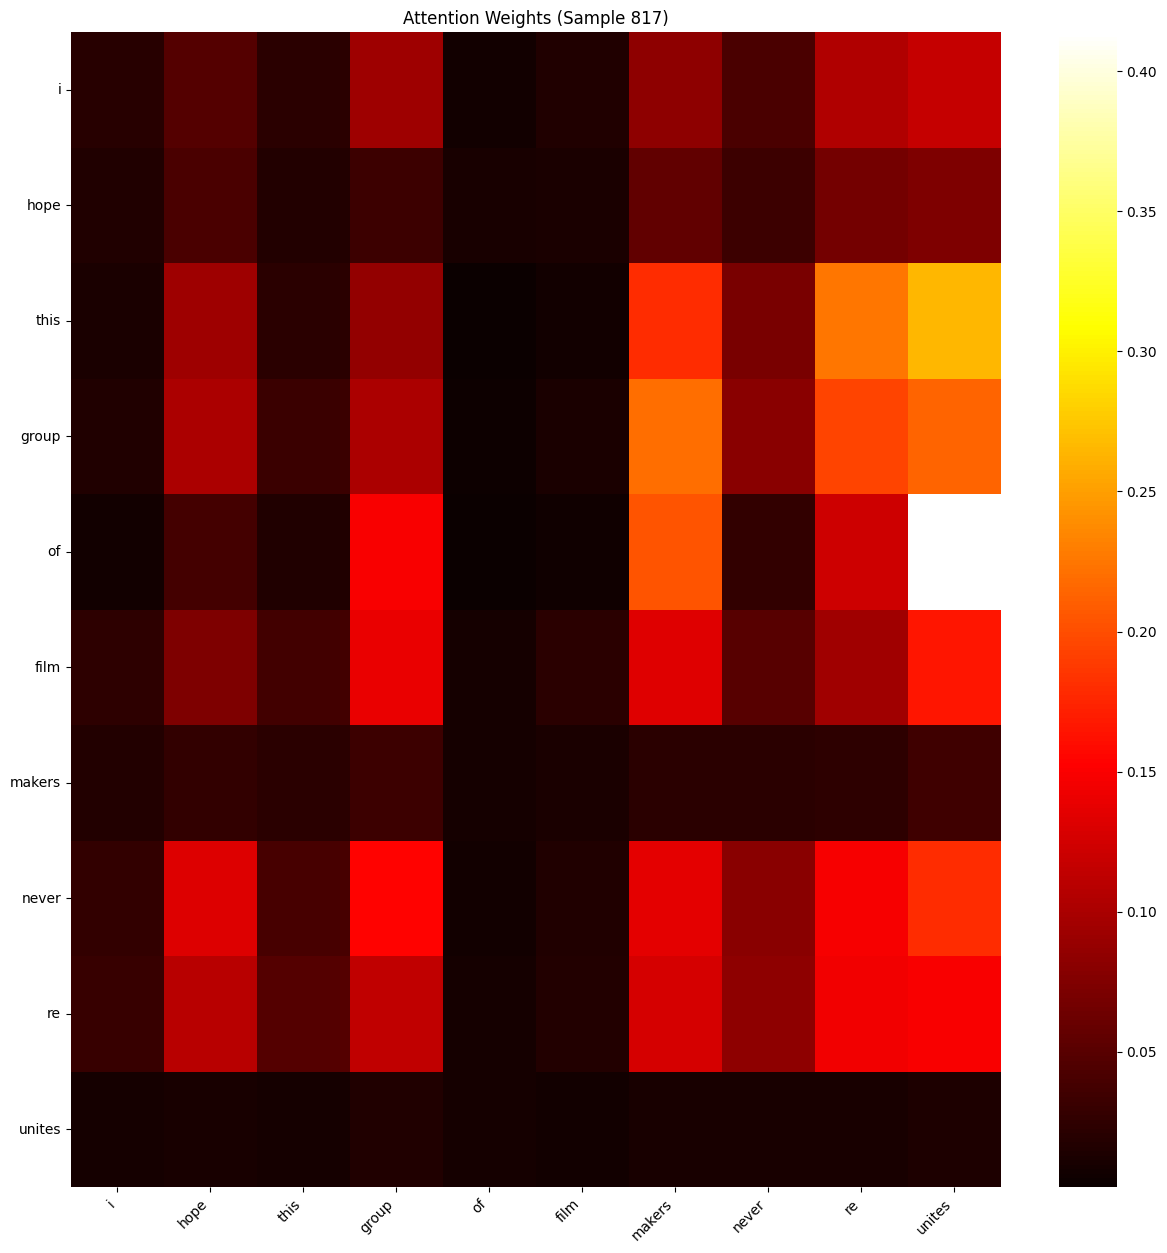

In [43]:
sample_index = 817
sample_input = tf.expand_dims(X_test_tokenized[sample_index], axis=0)
visualize_attention_weights(classifier, sample_input, sample_index, tokenizer)